# **MRR for QAC**

* [Introduction](#Introduction)
* [Formula](#Formula)
* [Interpreting RR representation](#Interpreting)
* [Loading the ES and WS Log Data](#Loading)
* [Generating the ES MRR json File](#GeneratingES)
* [Generating the WS MRR json File](#GeneratingWS)
* [MRR@k Calculation for both ES and WS](#MRR)
* [MRR Calculation Verification](#Verification)
* [Ablation Study using MRR](#Ablation)
* [References](#References)

# **Introduction** <a class="anchor"  id="Introduction"></a>
The evaluation of Query Auto-Complete (QAC) performance has two general approaches [23], each of which has its own metric: 
* (1) the **Mean Reciprocal Rank (MRR) metric** that focuses on the quality of ranking and 
* (2) the **Minimum Keystroke Length (MKS) metric** that focuses on savings of a user’s keystroke effort [26].

The focus of this study is ranking performance, and
we compute variants of the widely used MRR metric for evaluating QAC ranking performance [9, 14].
MRR is suitable for evaluating a list of possible responses to a sample of queries, ordered by the probability of correctness. 

In this code, we parse **Enterprise Search(ES)** and **Web Search(WS)** search log files to compute the MRR scores for various cut-offs.  The ES data is from an Apache Solr log file, wherease the WS data is from the AOL dataset published in 2006.

# **Formula** <a class="anchor"  id="Formula"></a>

The Reciprocal Rank (RR) of a query response is the multiplicative inverse of the rank of the first correct answer: 1 for first place, 1⁄3 for third place, or zero if the submitted query is not present in the ranked list [7]. The mean reciprocal rank is the average of the RR results for a sample of queries Q:


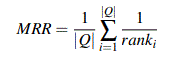


where rank<sub>i</sub> refers to the rank position of the first relevant document for the i<sup>th</sup> query. MRR only considers
the rank of the first relevant candidate (if there are further relevant candidates, they are ignored)

In [1]:
## Library imports
import numpy as np 
import pandas as pd
import subprocess # required to call a shell script 
import json
from IPython.display import HTML # pretty print

# **Interpreting RR representation** <a class="anchor"  id="Interpreting"></a>
The mrr-list file has been created by the [mrr.sh script ](http://https://github.com/ColinDaly75/Thesis-Supplementary-Information/blob/main/mrr.sh) which parses the solr log files, collecting the postion of selected PREFIX candidates for a given QUERY and assigns an RR score.

The [0,0,0,0,0,1] boolean represention means that, for a user's prefix, the correct candidate (sometimes referred to as **the 'golden' candidate**) was positioned 6th in the list.   Other examples RR representations are shown in the graphic below.

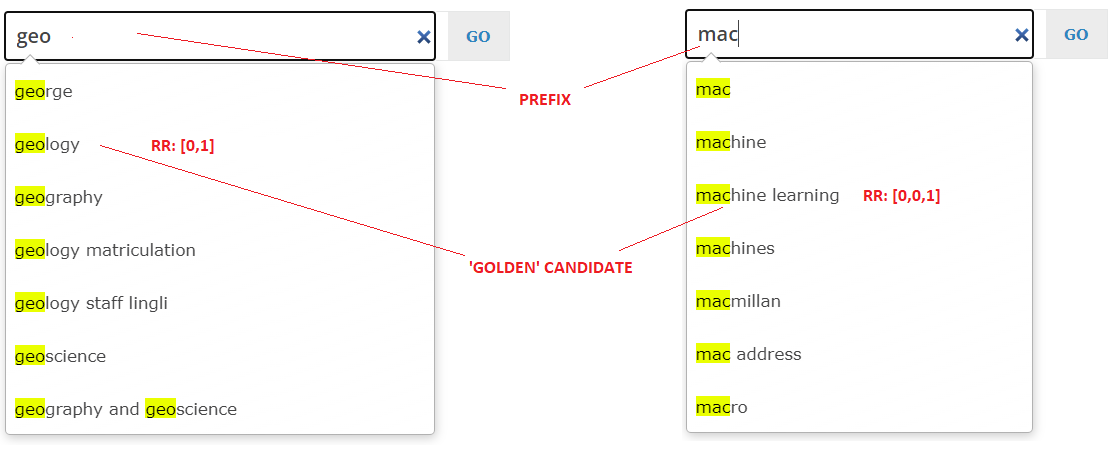

A representation of [1] indicates that the golden candidate was positioned on top of the suggestion lists.  Similarly, a representation of [0] would mean that the golden candidate did not make it onto the list of suggestions. 

Previously recorded queries can provide useful context for any user’s intent and can be leveraged
to suggest auto-completions that are more relevant while adhering to the user’s prefix. [8]. Most Popular Completions (MPC) is the main indicator of historical relevance [9].  MPC is widely used as a QAC baseline and can be regarded as an approximate maximum likelihood estimator [8,9] and hence we use it for our 'gold' standard.   

Limitations of MPC include i) single-objective ranking ii) cold starts iii)echo chamber iv)assumption that a click is a positive vote (rickrolling), iv) MPC assumes that current query popularity distribution will remain the same as previously observed


# **Loading the ES and WS Log Data** <a class="anchor"  id="Loading"></a>

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tcd-qac/AOL-completions-unigram-56-10000.txt
/kaggle/input/tcd-qac/mrr-es.sh
/kaggle/input/tcd-qac/mrr-ws.sh
/kaggle/input/tcd-qac/mrr-ws-list.json
/kaggle/input/tcd-qac/mrr-es-list.json
/kaggle/input/tcd-qac/solr.log


In [3]:
# ES = Enterprise Search (solr log data)
# WS = Web Search (AOL Logs from 2006 dataset)
ES_QAC_LOG_DATA="/kaggle/input/tcd-qac/mrr-es-list.json"
WS_QAC_LOG_DATA="/kaggle/input/tcd-qac/mrr-ws-list.json"


# **Generating the ES MRR json file** <a class="anchor"  id="GeneratingES"></a>

This code in this section requires access to the Solr Index and runs using the bash shell.   We can skip this sections if "ES_QAC_LOG_DATA=skip"
* INPUT=solr.log
* OUTPUT=mrr-es-list.json

In [4]:
ES_SCRIPT="/kaggle/input/tcd-qac/mrr-es.sh"
!cp -p /kaggle/input/tcd-qac/mrr-es.sh /kaggle/working/
!cp -p /kaggle/input/tcd-qac/solr.log /kaggle/working/
!chmod ugo+x /kaggle/working/mrr-es.sh
#!ls -l /kaggle/working/mrr-es.sh

# if running from kaggle, set ES_QAC_LOG_DATA to 'skip' as kaggle script cannot access solr index
ES_QAC_LOG_DATA="skip"

# The mrr.sh bash scipt takes about 2 minutes to run; 
if ES_QAC_LOG_DATA != "skip":
    rc = subprocess.call("/kaggle/working/mrr-es.sh")     # ouput goes to a file named mrr-es-list.json
else:
    print("Using previously generated mrr-es-list.json file")
    !cp -p /kaggle/input/tcd-qac/mrr-es-list.json /kaggle/working/
    
#double check formatting of mrr data file:
print ("Here is a sample of the json file:")
!head -3 mrr-es-list.json  # each element in the list of lists is in square brackets.
!tail -3 mrr-es-list.json  # note json format (last comma in list removed) and the final closing square bracket on a newline.


Using previously generated mrr-es-list.json file
Here is a sample of the json file:
[[0],
[],
[0,2],
[0],
[0] 
]


# **Generating the WS MRR json file** <a class="anchor"  id="GeneratingWS"></a>
This code in this section requires access to the Solr Index and runs using the bash shell.   We can skip this sections if "WS_QAC_LOG_DATA=skip"
* INPUT=AOL-completions-unigram-56-10000.txt
* OUTPUT=mrr-ws-list.json


In [5]:
WS_SCRIPT="/kaggle/input/tcd-qac/mrr-ws.sh"
!cp -p /kaggle/input/tcd-qac/mrr-ws.sh /kaggle/working/
!cp -p /kaggle/input/tcd-qac/AOL-completions-unigram-56-10000.txt /kaggle/working/   #change
!chmod ugo+x /kaggle/working/mrr-ws.sh
#!ls -l /kaggle/working/mrr-ws.sh

# if running from kaggle, set ES_QAC_LOG_DATA to 'skip' as kaggle script cannot access solr index
#WS_QAC_LOG_DATA="skip"
WS_QAC_LOG_DATA="AOL-completions-unigram-56-10000.txt"


# The mrr.sh bash scipt takes about 2 minutes to run; 
if WS_QAC_LOG_DATA != "skip":
    rc = subprocess.call("/kaggle/working/mrr-ws.sh")     # ouput goes to a file named mrr-ws-list.json
else:
    print("Using previously generated mrr-ws-list.json file")
    !cp -p /kaggle/input/tcd-qac/mrr-ws-list.json /kaggle/working/
    
#double check formatting of mrr data file:
print ("Here is a sample of the json file:")
!head -3 mrr-ws-list.json  # each element in the list of lists is in square brackets.
!tail -3 mrr-ws-list.json  # note json format (last comma in list removed) and the final closing square bracket on a newline.


output file (in json format) is mrr-ws-list.json

Here is a sample of the json file:
[[0,0,0,0,0,0,0,0,9],
[0],
[0,2],
[1],
[1] 
]

# **MRR@*k* calculation for both ES and WS** <a class="anchor"  id="MRR"></a>

We'll use [MRR@10 (Mean Reciprocal Rank)](https://en.wikipedia.org/wiki/Mean_reciprocal_rank), a metric which takes into account only the position of the first relevant document returned into the first 10 documents by each query. 

Whenever autocomplete suggestions start to exceed around 10 items on desktop (and fewer on mobile — around 7), users tend to either begin to ignore suggestions (at which point the additional suggestions become mere noise) or spend an inordinate amount of time reading suggestions (effectively halting their search process).

For this reason, the UX team that have designed our Enterprise Search service have limited the number of suggestions to 7 candidates.   For this reason, MRR@7 is the appropriate metric parameter.

We also include MRR@1 for informative purposes.

In [6]:
def mean_reciprocal_rank(bool_results, k=10):
    bool_results = (np.atleast_1d(r[:k]).nonzero()[0] for r in bool_results)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in bool_results])
# compare results for tidy and raw list, tidy list should be higher
#print(mean_reciprocal_rank(data,10))
#print(mean_reciprocal_rank(data_tidy,10))


In [7]:
qac_types = ["es", "ws"]
for x in qac_types:
    print ("mrr-" +x +"-list.json")

mrr-es-list.json
mrr-ws-list.json


In [8]:
qac_types = ["es", "ws"]
list = [('Type','MRR@','SCORE')]
for x in qac_types:
    #with open('mrr-ws-list.json', 'r') as f:
    with open("mrr-" +x +"-list.json", 'r') as f:
        data = json.load(f)
        data_tidy =   [x for x in data if x]     # remove emtpy items in list like [] , new format is [[0], [0, 0, 3], [1], [0], [0]]
        MRR_CUTOFFS = [1,5, 7, 10]   # higher CUTOFF should result in a higer score

        for COUNT in MRR_CUTOFFS:
            MRR_COUNT=mean_reciprocal_rank(data_tidy,COUNT)
            print ('The ' +x+ ' MRR@{}'.format(COUNT),"score is ""%.3f" %MRR_COUNT)
            list.append([x,COUNT,"%.3f" %MRR_COUNT])
        #print ("") # divider
        list.append(["-","-","-"])
    
# SCOREBOARD history  plot.savefig(f'hanning{num}.pdf')
# 27th-Feb-2024 v2 The MRR@10 score is 0.193
# 27th-Feb-2024 v4 The MRR@10 score is 0.187
# 28th-Feb-2024 v5 The MRR@10 score is 0.193
# 17th-Mar-2024 v6 The MRR@10 score is 0.192
# 27-May-2024   v7 The MRR@10 score is 0.225
# 28-May-2024   fathead node2 The MRR@10 score is 0.683
# 18-Jun-2024   mrr-list.json score is .231

#df = pd.DataFrame(list)
# print dataframe.
#print(df)

The es MRR@1 score is 0.180
The es MRR@5 score is 0.230
The es MRR@7 score is 0.231
The es MRR@10 score is 0.231
The ws MRR@1 score is 0.291
The ws MRR@5 score is 0.356
The ws MRR@7 score is 0.361
The ws MRR@10 score is 0.364


In [9]:
#express the above in table form
df = pd.DataFrame(list)
df = df.rename(columns=df.iloc[0]).drop(df.index[0])   #first row of tables becomes header
HTML(df.to_html(index=False))


Type,MRR@,SCORE
es,1,0.180
es,5,0.230
es,7,0.231
es,10,0.231
-,-,-
ws,1,0.291
ws,5,0.356
ws,7,0.361
ws,10,0.364
-,-,-


# **MRR Calculation Verification** <a class="anchor"  id="Verification"></a>
In this section we check that all records in the MRR list are accounted for.

In [10]:
print(data_tidy)   # should have no empty lists like [] .Caution: data list order is not preserved

[[0, 0, 0, 0, 0, 0, 0, 0, 9], [0], [0, 2], [1], [0], [1], [0], [1], [1], [0], [0], [0, 2], [0], [0], [1], [1], [0], [0, 0, 0, 0, 0, 6], [0], [0], [1], [0], [1], [1], [0], [0], [0, 2], [0], [0], [0], [0], [0], [0], [1], [0], [1], [1], [1], [0, 0, 3], [0, 2], [0], [1], [0], [0, 0, 0, 4], [0], [0], [0], [0], [1], [1], [0, 0, 0, 0, 0, 6], [0], [0, 0, 3], [0], [0, 0, 0, 0, 0, 0, 7], [0, 0, 0, 0, 0, 0, 7], [0], [0, 0, 3], [0, 0, 3], [0, 0, 3], [0], [0], [0, 2], [1], [0], [0, 2], [0], [0], [0], [0], [0], [0, 0, 0, 0, 0, 6], [0], [1], [0], [1], [0], [0], [0], [0], [0], [0], [0, 2], [0], [1], [0, 2], [0, 0, 0, 0, 0, 0, 0, 0, 9], [0], [1], [0], [0, 0, 0, 0, 0, 0, 0, 8], [0, 2], [1], [0, 0, 0, 0, 0, 0, 7], [1], [1], [1], [1], [0], [0], [0], [0, 2], [0], [0], [0], [1], [0], [0], [1], [0], [0], [0, 2], [0], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [0], [0], [1], [1], [0], [0], [0, 0, 0, 4], [1], [0], [0], [1], [0, 0, 0, 0, 5], [0, 0, 0, 0, 5], [1], [1], [1], [

In [11]:
!wc -l /kaggle/input/tcd-qac/mrr-es-list.json # should match number of elements in data array (below, not count is one higher due last line)

763 /kaggle/input/tcd-qac/mrr-es-list.json


In [12]:
!cat /kaggle/input/tcd-qac/mrr-es-list.json  | grep "\[\]" | wc -l   # should match number of elements removed (below)

212


In [13]:
print("Number of elements in 'data' mrr list:",len(data))
print("Number of elements in 'data_tidy' (processed) mrr list:",len(data_tidy))
print("The number of empty list elements, i.e. where qac was unavailable, is:", len(data)-len(data_tidy))  # number of empty list elements, must be a positive number.


Number of elements in 'data' mrr list: 361
Number of elements in 'data_tidy' (processed) mrr list: 361
The number of empty list elements, i.e. where qac was unavailable, is: 0


# **ToDo**

1. A/A test incl std-deviation and t-test.  Hypothesis
2. A/B test after implementation of new Feature.  Next Phase.
3. MRR scores for top most poprular 15 queries 
4. explain MPC is used to baseline the 'golden' candidates.  DONE

# **Ablation Study** <a class="anchor"  id="Ablation"></a>

Ablation/leave-one-out analysis showing the contribution of individual features to the MRR performance across the QAC ranking models. Red line shows impact of on Ranking performance using the additive feature layers. 

A set of experiments in which features in our LTR Ranking model are removed/replaced in order to measure the impact of these features on the performance of the system.


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    'Feature': ['TF', 'MPC', 'MFQ', 'AOL', 'TREND', 'QACES'],
    'MRR@1': [0.05,      0.12, 0.09,   0.02,  0.03,    0.03],
    'MRR@3': [0.05,      0.17, 0.10,   0.02,  0.04,    0.03],
    'MRR@7': [0.06,      0.19, 0.11,   0.02,  0.04,    0.04],
    'MRR@10':[0.07,      0.23, 0.13,   0.03,  0.04,    0.04],
}

data = {
    'Feature': ['TF', 'MFQ', 'AOL', 'TREND', 'QACES'],
    'MRR@1': [0.05,      0.09,   0.02,  0.03,    0.03],
    'MRR@3': [0.05,      0.10,   0.02,  0.04,    0.03],
    'MRR@7': [0.06,      0.11,   0.02,  0.04,    0.04],
    'MRR@10':[0.07,      0.13,   0.03,  0.04,    0.04],
}


df = pd.DataFrame(data)
df['Additive_Total'] = df['MRR@10'].cumsum()
print (df)

  Feature  MRR@1  MRR@3  MRR@7  MRR@10  Additive_Total
0      TF   0.05   0.05   0.06    0.07            0.07
1     MFQ   0.09   0.10   0.11    0.13            0.20
2     AOL   0.02   0.02   0.02    0.03            0.23
3   TREND   0.03   0.04   0.04    0.04            0.27
4   QACES   0.03   0.03   0.04    0.04            0.31


Although MPC is typically considered the main indicator of historical relevance~\cite{li-google-2017}, it cannot be included as a feature here (since we already use it as a proxy for ground truth (i.e. the target variable) in our LTR dataset).} This exclusion prevents target leakage, where the model could learn spurious correlations between the predictors (features) and the target variable.

A grouped barplot is used since we have several groups (i.e. 5 features), and subgroups  (i.e. 4 MRR scores) of these groups.

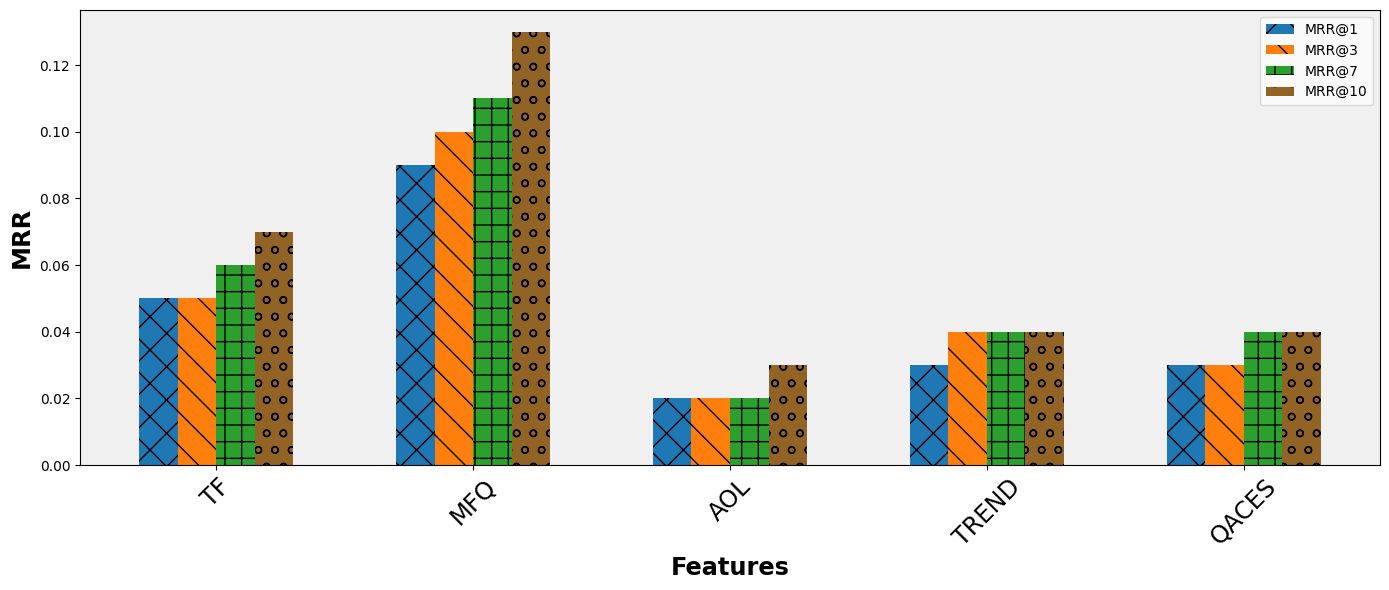

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
#ax2 = ax.twinx()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#916324', '#9467bd']
patterns = ['x', '\\', '+', 'o', '|']

bar_width = 0.15
bar_positions = np.arange(len(df['Feature']))
for i, col in enumerate(['MRR@1', 'MRR@3', 'MRR@7', 'MRR@10']):
    ax.bar(bar_positions + i*bar_width, df[col], bar_width, label=col, color=colors[i], hatch=patterns[i])

#ax2.plot(df['Feature'], df['Additive_Total'], color="red", linestyle="--", linewidth=2)
#line_label = 'Total MRR'
#ax.plot([], [], color="red", linestyle="--", linewidth=2, label=line_label)

legend = ax.legend(loc='upper right', fontsize='medium', title_fontsize='xx-large', fancybox=True)
legend.get_frame().set_alpha(0.7)

ax.set_facecolor('#f0f0f0')
#ax2.set_facecolor('#f0f0f0')
ax.set_xlabel("Features", fontweight='bold',fontsize='xx-large')
ax.set_ylabel("MRR", fontweight='bold',fontsize='xx-large')
#ax2.set_ylabel("MRR", fontweight='bold')
plt.xticks(bar_positions + 1.5*bar_width, df['Feature'], rotation=45,fontsize='xx-large')

plt.tight_layout()
plt.savefig('Fig-QAC-MRR-Ablation.png', bbox_inches='tight')   

plt.show()

# **References** <a class="anchor"  id="References"></a>

[23] Y. Chang and H. Demg, Query Understanding for Search Engines, ser. The Information Retrieval Series. Jilin: Springer
International Publishing, 2020, vol. 46.

[26] H. Duan and B. J. Hsu, “Online spelling correction for query completion,” Proceedings of the 20th International Conference on World Wide Web, WWW 2011, pp. 117–126, 2011.

[8] N. Yadav, R. Sen, D. N. Hill, A. Mazumdar, and I. S. Dhillon, “Session-Aware Query Auto-completion using Extreme MultiLabel Ranking,” Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 3835–3844, 8 2021. 

[9] L. Li, H. Deng, A. Dong, Y. Chang, R. BaezaYates, and H. Zha, “Exploring query autocompletion and click logs for contextualaware web search and query suggestion,” 26th International World Wide Web Conference, WWW 2017, pp. 539–548, 2017

[14] F. Cai and M. De Rijke, “A survey of query auto completion in information retrieval,” Foundations and Trends in Information Retrieval, vol. 10, no. 4, pp. 273–363, 2016.